In [185]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [186]:
# Define column names
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 27)]
train_df = pd.read_csv('./dataset/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_df = pd.read_csv('./dataset/test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('./dataset/RUL_FD001.txt', header=None)

# Notebook Structure

- [Data Preprocessing](#Data-Preprocessing)
    - [Dropping Columns](##Dropping-columns)
    - [Normalization](##Normalization)
    - [Data Labelling](#data-labelling)
    - [Splitting Training Data for Validation (By Engine ID)](#Splitting-Training-Data-For-Validation)
- [Regression](#regression)
    - [Preparing Data with Sliding Window](#Prepping-Data-for-Regression)
    - [Feature Extraction with TSFRESH](#Feature-Extraction)
    - [Dimensionality Reduction with PCA](#Feature-Selection)
    - [Linear Regression](#linear-regression)
        - [Training Linear Regression](#training)
        - [Validation of Training Data](#Validation)
        - [Predicting on Test Data](#Predict)
    - [Random Forest (tbc)](#random-forest)
    - [Gradient Boosting (tbc)](#gradient-boosting)
- [Other Models](#others)
    - [Preparation of Data for LSTM, Bi-LSTM, CNN-LSTM (Sliding Window)](#Data-preparation)
    - [Training of Models](#training)
        - [LSTM](#LSTM)
        - [Bi-LSTM](#Bi-LSTM)
        - [CNN-LSTM](#CNN-LSTM)
    - [Validation of Models](#validation)
        - [LSTM](#validate-lstm)
        - [Bi-LSTM](#validate-bilstm)
        - [CNN-LSTM](#validate-cnnlstm)
    - [Prediction of Models](#prediction)
        - [LSTM](#predict-lstm)
        - [Bi-LSTM](#predict-bilstm)
        - [CNN-LSTM](#predict-cnnlstm)
- [Exploring Novel Techniques (Bi-LSTM Two-Stream Approach)](#Extra-Apprach-(Two-Steam))
- [Comparing Models](#Comparison)

# Data Preprocessing

## Dropping columns
- As mentioned during EDA, we will be dropping these columns based on the findings

In [187]:
# Dropping Columns
columns_to_drop = ["setting1", "setting2", "setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor22", "sensor23", "sensor24", "sensor25", "sensor26"]
train_df_dropped = train_df.drop(columns=columns_to_drop)
test_df_dropped = test_df.drop(columns=columns_to_drop)

## Normalization

In [188]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Separate the columns to normalize and the columns to skip
columns_to_skip = train_df_dropped.columns[:2]
columns_to_normalize = train_df_dropped.columns[2:]

# Normalize only the selected columns
normalized_data = scaler.fit_transform(train_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
train_df_normalized = pd.DataFrame(train_df_dropped[columns_to_skip].values, columns=columns_to_skip)
train_df_normalized = pd.concat([train_df_normalized, pd.DataFrame(normalized_data, columns=columns_to_normalize)], axis=1)

# Normalize the test data
test_normalized_data = scaler.transform(test_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
test_df_normalized = pd.DataFrame(test_df_dropped[columns_to_skip].values, columns=columns_to_skip)
test_df_normalized = pd.concat([test_df_normalized, pd.DataFrame(test_normalized_data, columns=columns_to_normalize)], axis=1)

# Display the normalized DataFrame
print("Normalized Data (0-1 range):")
print(train_df_normalized.head())

Normalized Data (0-1 range):
   engine_id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8  \
0          1      1  0.183735  0.406802  0.309757  0.726248  0.242424   
1          1      2  0.283133  0.453019  0.352633  0.628019  0.212121   
2          1      3  0.343373  0.369523  0.370527  0.710145  0.272727   
3          1      4  0.343373  0.256159  0.331195  0.740741  0.318182   
4          1      5  0.349398  0.257467  0.404625  0.668277  0.242424   

    sensor9  sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  \
0  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333   
1  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333   
2  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667   
3  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333   
4  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667   

   sensor20  sensor21  
0  0.713178  0.724662  
1  0.666667  0.731014  
2  0.6279

## Data Labelling

In [189]:
# Labelling of Data with RUL and Piecewise
# 1) Labelling RUL
train_df_normalized['RUL'] = train_df_normalized.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# 2) Labelling PWRUL
# Set the early RUL threshold
early_rul_threshold = 125

# Define the piecewise linear degradation function
def piecewise_rul(cycle, max_cycle):
    remaining_life = max_cycle - cycle
    if remaining_life > early_rul_threshold:
        return early_rul_threshold  # slower degradation in the early phase
    else:
        return remaining_life  # direct linear degradation after threshold
    
train_df_normalized["PWRUL"] = train_df_normalized.apply(lambda row: piecewise_rul(row['cycle'], row['cycle'] + row['RUL']), axis=1)

## Splitting Training Data For Validation
- Split is done by engine id

In [190]:
from sklearn.model_selection import train_test_split

# Step 1: Extract Unique Engine IDs
engine_ids = train_df_normalized['engine_id'].unique()

# Step 2: Split Engine IDs into Training and Testing Sets
train_engine_ids, test_engine_ids = train_test_split(
    engine_ids, test_size=0.2, random_state=42
)

# Step 3: Filter Data Based on Engine IDs
train_data = train_df_normalized[train_df_normalized['engine_id'].isin(train_engine_ids)].reset_index(drop=True)
validation_data = train_df_normalized[train_df_normalized['engine_id'].isin(test_engine_ids)].reset_index(drop=True)


# Regression

## Prepping Data for Linear Regression
- Sliding Window Approach

In [191]:
feature_dfs = []
label_list = []

# Define the window size (e.g., last 30 cycles)
window_size = 30

# List of Sensors
sensor_list = list(train_df_normalized.columns[2:16])

# For all training data, split to windows of 30, step 1
for engine_id in train_df_normalized['engine_id'].unique():
    engine_data = train_df_normalized[train_df_normalized['engine_id'] == engine_id]
    max_cycle = engine_data['cycle'].max()
    for i in range(window_size, max_cycle + 1):
        window_data = engine_data[(engine_data['cycle'] >= i - window_size) & (engine_data['cycle'] <= i)]
        # Assign unique IDs for tsfresh
        window_data = window_data.copy()
        window_data['id'] = f'{engine_id}_{i}'
        
        # Corrected line: Convert Index to list before concatenation
        columns_to_select = ['id', 'cycle'] + sensor_list
        
        # Append to the list using the corrected columns
        feature_dfs.append(window_data[columns_to_select])
        
        # Get the RUL at this point
        rul = engine_data[engine_data['cycle'] == i]['PWRUL'].values[0]
        label_list.append({'id': f'{engine_id}_{i}', 'PWRUL': rul})

tsfresh_input_df = pd.concat(feature_dfs)
tsfresh_input_df.shape

(549561, 16)

In [192]:
# Labels for Linear Regression
labels_df = pd.DataFrame(label_list)

### Feature Extraction with Tsfresh

In [193]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
extraction_settings = MinimalFCParameters()

extracted_features = extract_features(
    tsfresh_input_df,
    column_id='id',
    column_sort='cycle',
    default_fc_parameters=extraction_settings,
    n_jobs=4
)

Feature Extraction: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [194]:
# Saving the DataFrame
# import pickle
# extracted_features.to_pickle('extracted_features.pkl')

# Loading the DataFrame
# extracted_features = pd.read_pickle('extracted_features.pkl')

### Dimension Reduction with PCA

In [195]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler() # PCA requires scaling
scaled_features = scaler.fit_transform(extracted_features.values)
pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(scaled_features)
X_pca_df = pd.DataFrame(X_pca, index=extracted_features.index)
X_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
100_100,-1.234776,0.261028,0.324893,-0.244710,-0.417715,-1.489282,2.188189,0.886255,-0.628759,0.006275,-2.237246,0.064114,-1.145264,-0.101255
100_101,-1.161567,0.295693,0.323424,-0.074507,-0.698084,-1.382350,2.109476,0.885346,-0.664326,0.094947,-2.260421,-0.300300,-0.836293,0.071280
100_102,-1.017447,0.276795,0.316344,-0.251708,-0.438848,-1.758021,2.258539,1.102260,-0.231912,0.407066,-2.186305,-0.471042,-0.301305,0.072629
100_103,-0.768150,0.393663,0.300682,0.219953,-0.466147,-1.759550,2.901416,1.391060,-0.037482,0.946336,-2.332961,-0.081158,-0.333296,0.214995
100_104,-0.826586,0.342560,0.304725,0.024288,-0.176945,-1.556616,2.728529,1.182248,-0.184759,0.852959,-2.213581,-0.045305,-0.226964,0.169577


In [196]:
features_labels_df = X_pca_df.merge(labels_df, left_index=True, right_on='id')
features_labels_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,id,PWRUL
17630,-1.234776,0.261028,0.324893,-0.244710,-0.417715,-1.489282,2.188189,0.886255,-0.628759,0.006275,-2.237246,0.064114,-1.145264,-0.101255,100_100,100.0
17631,-1.161567,0.295693,0.323424,-0.074507,-0.698084,-1.382350,2.109476,0.885346,-0.664326,0.094947,-2.260421,-0.300300,-0.836293,0.071280,100_101,99.0
17632,-1.017447,0.276795,0.316344,-0.251708,-0.438848,-1.758021,2.258539,1.102260,-0.231912,0.407066,-2.186305,-0.471042,-0.301305,0.072629,100_102,98.0
17633,-0.768150,0.393663,0.300682,0.219953,-0.466147,-1.759550,2.901416,1.391060,-0.037482,0.946336,-2.332961,-0.081158,-0.333296,0.214995,100_103,97.0
17634,-0.826586,0.342560,0.304725,0.024288,-0.176945,-1.556616,2.728529,1.182248,-0.184759,0.852959,-2.213581,-0.045305,-0.226964,0.169577,100_104,96.0
17635,-0.636066,0.196279,0.303692,-0.362498,-0.376835,-1.477411,2.548305,1.205811,-0.077386,0.777515,-1.384116,-0.581043,-0.575374,-0.505253,100_105,95.0
17636,-0.587227,0.098911,0.310798,-0.776737,-0.206950,-1.406787,2.563503,1.382722,-0.042925,0.642046,-1.232666,-0.258892,-0.382367,-0.125541,100_106,94.0
17637,-0.559622,-0.002555,0.315724,-1.085004,0.000090,-1.378910,2.508510,1.272886,-0.026698,0.300891,-0.854633,-0.427325,-0.657371,-0.365937,100_107,93.0
17638,-0.575560,0.050630,0.306879,-0.872143,0.524591,-1.172975,2.965263,1.247938,0.126665,0.766277,-0.472792,-0.747819,-0.637720,-0.551579,100_108,92.0
17639,-0.547421,0.047310,0.305270,-0.950258,0.842033,-1.130564,2.980201,1.211953,0.098403,1.075626,-0.433022,-0.885082,-0.594876,-0.618035,100_109,91.0


### Splitting the data by engines

In [197]:
# Extract engine IDs from 'id'
features_labels_df['engine_id'] = features_labels_df['id'].apply(lambda x: x.split('_')[0])
features_labels_df['engine_id'] = features_labels_df['engine_id'].astype(int) # cast type to int for masking

# Create masks for training and testing data
train_mask = features_labels_df['engine_id'].isin(train_engine_ids)
test_mask = features_labels_df['engine_id'].isin(test_engine_ids)


X_train = features_labels_df[train_mask].drop(['id', 'PWRUL', 'engine_id'], axis=1)
X_test = features_labels_df[test_mask].drop(['id', 'PWRUL', 'engine_id'], axis=1)
y_train = features_labels_df[train_mask]['PWRUL']
y_test = features_labels_df[test_mask]['PWRUL']

In [198]:
print("Total unique engine IDs:", features_labels_df['engine_id'].nunique())
print("Number of engine IDs in training set:", len(train_engine_ids))
print("Number of engine IDs in testing set:", len(test_engine_ids))
print("Overlap between training and testing IDs:", set(train_engine_ids).intersection(set(test_engine_ids)))

Total unique engine IDs: 100
Number of engine IDs in training set: 80
Number of engine IDs in testing set: 20
Overlap between training and testing IDs: set()


# Linear Regression

## Training the Linear Regression

In [199]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Validation for Linear Regresssion Model

In [200]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

19.39301861731811

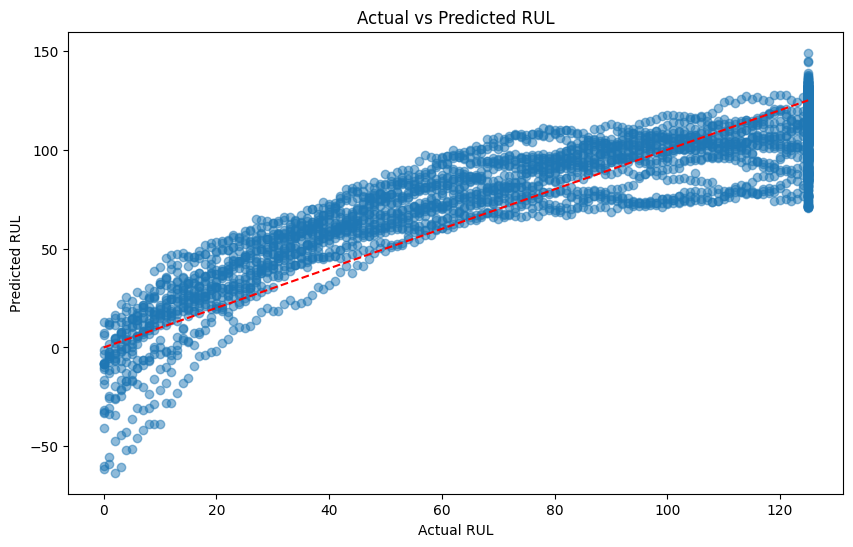

In [201]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

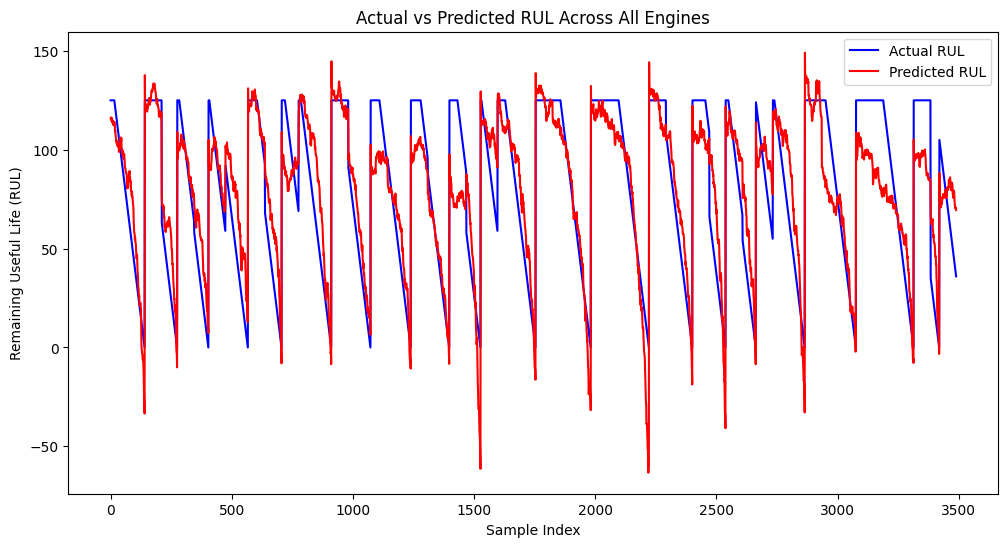

In [202]:
results_df = pd.DataFrame({
    'Actual RUL': y_test,
    'Predicted RUL': y_pred
})
# Reset the index to ensure sequential ordering
results_df = results_df.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual RUL'], label='Actual RUL', color='blue')
plt.plot(results_df['Predicted RUL'], label='Predicted RUL', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL Across All Engines')
plt.legend()
plt.show()

## Prediction for Linear Regresssion Model

In [203]:
# Prepping test data
## Same process as training data but only take the latest window (i.e. latest 30 records)
test_feature_dfs = []
test_label_list = []

for engine_id in test_df_normalized['engine_id'].unique():
    # Filter data for the current engine
    engine_data = test_df_normalized[test_df_normalized['engine_id'] == engine_id].reset_index(drop=True)
    
    # Ensure there are enough cycles for the window
    if len(engine_data) >= window_size:
        # Use only the last 30 cycles
        window_data = engine_data.iloc[-window_size:].copy()
        window_data['id'] = f'{engine_id}_test'  # Assign a unique ID for this test sample
        
        # Select the necessary columns for tsfresh
        columns_to_select = ['id', 'cycle'] + sensor_list  # Replace 'sensor_list' with your actual list of sensor columns
        test_feature_dfs.append(window_data[columns_to_select])
        

# Step 2: Concatenate the test data for feature extraction
test_tsfresh_input_df = pd.concat(test_feature_dfs)

# Step 3: Extract features using tsfresh
test_extracted_features = extract_features(
    test_tsfresh_input_df,
    column_id='id',
    column_sort='cycle',
    default_fc_parameters=extraction_settings,
    n_jobs=4
)


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 13.16it/s]


In [204]:
# Scaling and PCA
scaled_test_features = scaler.transform(test_extracted_features.values)
X_test_pca = pca.transform(scaled_test_features)
X_test_pca_df = pd.DataFrame(X_test_pca, index=test_extracted_features.index)
X_test_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
100_test,3.014737,12.558243,-50.781387,-2.108442,-0.335100,-1.440751,2.147379,1.399515,-0.241003,-2.126381,0.126023,-1.583719,3.128059,0.749156
10_test,-4.986281,-3.429474,-49.444549,0.406565,2.313361,-2.042894,-1.822104,-1.397880,-1.419736,-0.312035,-0.200554,-0.880435,1.737540,1.611935
11_test,2.163355,-10.157140,-49.182554,-1.055662,-2.464546,4.156856,0.263141,-1.871915,-0.518364,0.704283,-1.291378,-0.970707,1.070670,-0.705843
12_test,-7.865826,-2.014538,-49.438771,-1.570209,-0.312831,1.039496,1.418867,-1.159780,-0.369461,0.584893,1.775087,-0.402908,-1.743866,0.169788
13_test,-4.978519,-3.505508,-49.420568,-0.774098,-0.803342,-2.149552,-0.445184,1.773144,0.466532,1.571758,-0.471156,-0.054840,-0.368390,-0.117074


In [205]:
# Sorting
X_test_pca_df['engine_id'] = X_test_pca_df.index.str.split('_').str[0].astype(int)
X_test_pca_df_sorted = X_test_pca_df.sort_values(by='engine_id')
X_test_pca_df_sorted = X_test_pca_df_sorted.drop(columns=['engine_id'])
X_test_pca_df_sorted

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1_test,-10.487599,-6.248105,-49.074206,-1.020081,-1.630058,-0.136122,-1.230878,0.065003,-2.036380,-2.628369,-0.541577,0.935060,0.328449,0.443998
2_test,-2.089419,-7.493681,-49.242472,-2.013363,-1.152580,0.354055,-0.776673,0.458821,-0.895680,-1.552363,-0.289613,-1.615734,-0.063796,-0.985631
3_test,3.859838,-7.916308,-49.375259,-0.977358,-0.342840,-0.037841,0.636571,2.692476,-2.516975,-0.943406,-0.637291,-0.838236,-1.102894,-1.330533
4_test,-0.029972,-6.692746,-49.342838,-1.406931,-1.843582,-1.258684,1.169237,-1.444251,-1.366029,-0.177231,0.710757,0.805901,0.482353,2.282022
5_test,0.241244,-6.575453,-49.382336,-0.189830,-0.767398,-1.315416,-1.628168,0.331799,0.994889,-0.035864,-0.232093,-0.098475,0.891339,-0.038106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_test,-12.698974,-1.440914,-49.343697,-0.089678,0.868491,-0.500125,-2.781378,-1.469658,-1.170617,0.619779,-1.954811,0.838917,-0.089757,0.336313
97_test,-8.205856,-1.386738,-49.443496,-3.869966,-1.106815,-1.727254,0.511005,0.928374,0.570518,-1.911107,0.456484,-1.109056,-1.357207,1.146132
98_test,-0.585149,-4.493312,-49.475670,-2.637977,-1.469203,0.988421,-1.340553,-1.748524,2.149991,-0.813039,-0.286433,-0.829956,0.676667,1.166566
99_test,-15.145424,-1.540001,-49.258480,-1.064116,0.331092,-2.410528,1.066118,1.702556,-0.578529,0.769320,0.173035,-0.575184,-0.887212,-0.773633


In [206]:
y_pred = model.predict(X_test_pca_df_sorted)
rmse = np.sqrt(mean_squared_error(true_rul[0], y_pred))
print("RMSE on Test Data:", rmse)

RMSE on Test Data: 26.365781114901704


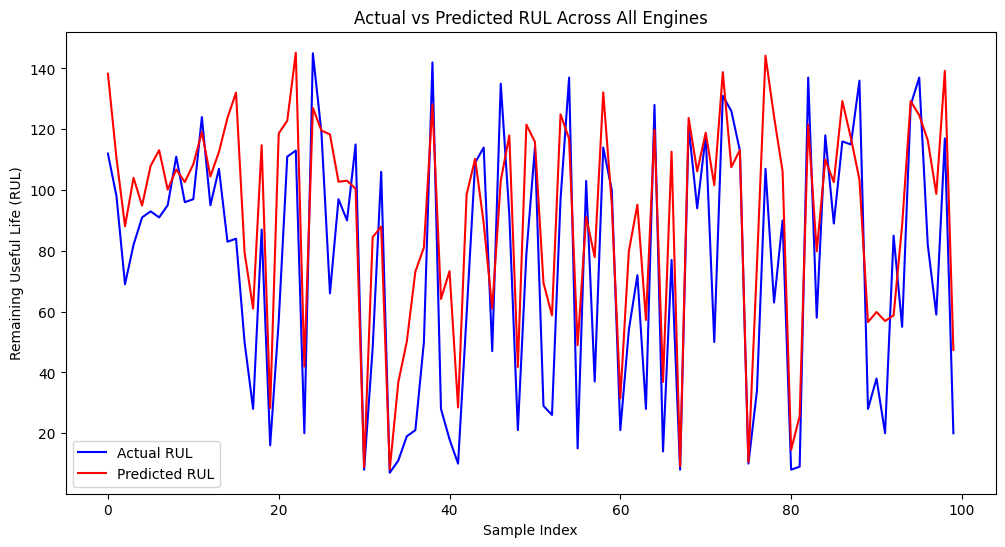

In [207]:
results_df = pd.DataFrame({
    'Actual RUL': true_rul[0],
    'Predicted RUL': y_pred
})
# Reset the index to ensure sequential ordering
results_df = results_df.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual RUL'], label='Actual RUL', color='blue')
plt.plot(results_df['Predicted RUL'], label='Predicted RUL', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('Actual vs Predicted RUL Across All Engines')
plt.legend()
plt.show()

## Prepping Data using Sliding Window for LSTM, Bi-LSTM, CNN-LSTM

In [208]:
# Prepping training data
sequence_length = 30

# Identify feature columns
feature_columns = [col for col in train_data.columns if col not in ['engine_id', 'cycle', 'RUL', 'PWRUL']]

# Initialize lists for sequences and labels
X = []
y = []

# Generate sequences and labels
# Sliding window approach
for engine_id in train_data['engine_id'].unique():
    engine_data = train_data[train_data['engine_id'] == engine_id].reset_index(drop=True)
    for i in range(sequence_length, len(engine_data)):
        # Extract sequence of sensor readings
        seq_x = engine_data[feature_columns].iloc[i-sequence_length:i].values
        # Extract the RUL value at the end of the sequence
        seq_y = engine_data['PWRUL'].iloc[i]
        X.append(seq_x)
        y.append(seq_y)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print("Input shape:", X.shape)
print("Labels shape:", y.shape)

Input shape: (14161, 30, 14)
Labels shape: (14161,)


In [209]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional

# Training LSTM

In [210]:
# LSTM
lstm_model = Sequential()

# LSTM layers for temporal pattern recognition
lstm_model.add(LSTM(units=128, return_sequences=True, activation='tanh', input_shape=(sequence_length, len(feature_columns))))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, activation='tanh'))
lstm_model.add(Dropout(0.2))

# Fully connected layers
lstm_model.add(Dense(units=96, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=128, activation='relu'))
lstm_model.add(Dropout(0.2))

# Output layer
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
print(lstm_model.summary())

# Training the Model
history = lstm_model.fit(X, y, 
                         epochs=50, 
                         batch_size=64)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 128)           73216     
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 96)               

# Training CNN-LSTM

In [211]:
# CNN-LSTM
# Define the model (CNN-LSTM)
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_columns))))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=100))
cnn_lstm_model.add(Dense(units=1))

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

print(cnn_lstm_model.summary())

# Training the Model
history = cnn_lstm_model.fit(X, y, 
                    epochs=50, 
                    batch_size=64)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 64)            2752      
                                                                 
 conv1d_3 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 100)               66000     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 81,205
Trainable params: 81,205
Non-trainable params: 0
__________________________________________________

# Training Bi-LSTM

In [212]:
 # Define the model
bi_lstm_model = Sequential()

# Bidirectional LSTM layers
bi_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh'), input_shape=(sequence_length, len(feature_columns))))
bi_lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))
bi_lstm_model.add(Bidirectional(LSTM(units=32, activation='tanh')))

# Fully connected layers
bi_lstm_model.add(Dense(units=96, activation='relu'))
bi_lstm_model.add(Dense(units=128, activation='relu'))

# Output layer
bi_lstm_model.add(Dense(units=1))

# Compile the model
bi_lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = bi_lstm_model.fit(X, y, 
                           epochs=15, 
                        #    validation_data=(processed_val_data, processed_val_targets),
                           batch_size=64, 
                           verbose=2)


Epoch 1/15
222/222 - 16s - loss: 2625.8628 - 16s/epoch - 72ms/step
Epoch 2/15
222/222 - 12s - loss: 1755.0625 - 12s/epoch - 55ms/step
Epoch 3/15
222/222 - 12s - loss: 1228.0367 - 12s/epoch - 55ms/step
Epoch 4/15
222/222 - 12s - loss: 441.5560 - 12s/epoch - 55ms/step
Epoch 5/15
222/222 - 12s - loss: 417.7748 - 12s/epoch - 55ms/step
Epoch 6/15
222/222 - 12s - loss: 398.5636 - 12s/epoch - 55ms/step
Epoch 7/15
222/222 - 12s - loss: 387.0673 - 12s/epoch - 55ms/step
Epoch 8/15
222/222 - 12s - loss: 350.7354 - 12s/epoch - 56ms/step
Epoch 9/15
222/222 - 13s - loss: 305.9471 - 13s/epoch - 57ms/step
Epoch 10/15
222/222 - 13s - loss: 255.7817 - 13s/epoch - 58ms/step
Epoch 11/15
222/222 - 13s - loss: 221.2981 - 13s/epoch - 58ms/step
Epoch 12/15
222/222 - 13s - loss: 208.8693 - 13s/epoch - 58ms/step
Epoch 13/15
222/222 - 13s - loss: 191.4339 - 13s/epoch - 59ms/step
Epoch 14/15
222/222 - 13s - loss: 184.8759 - 13s/epoch - 59ms/step
Epoch 15/15
222/222 - 13s - loss: 181.2741 - 13s/epoch - 59ms/step


# Validation of Models

In [213]:
# Prepping validation data
X_test = []
y_test = []

for engine_id in validation_data['engine_id'].unique():
    engine_data = validation_data[validation_data['engine_id'] == engine_id].reset_index(drop=True)
    for i in range(sequence_length, len(engine_data)):
        # Extract sequence of sensor readings
        seq_x = engine_data[feature_columns].iloc[i - sequence_length:i].values
        X_test.append(seq_x)
        # Extract the target value at the end of the sequence -> PWRUL in this case
        seq_y = engine_data['PWRUL'].iloc[i]  
        y_test.append(seq_y)

X_test = np.array(X_test)
y_test = np.array(y_test)

### Validating LSTM

In [214]:
from sklearn.metrics import mean_squared_error
# Validation with LSTM
lstm_validation_y_test_pred = lstm_model.predict(X_test)
lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, lstm_validation_y_test_pred))
lstm_validation_rmse

109/109 [==============================] - 1s 8ms/step


12.746839101720385

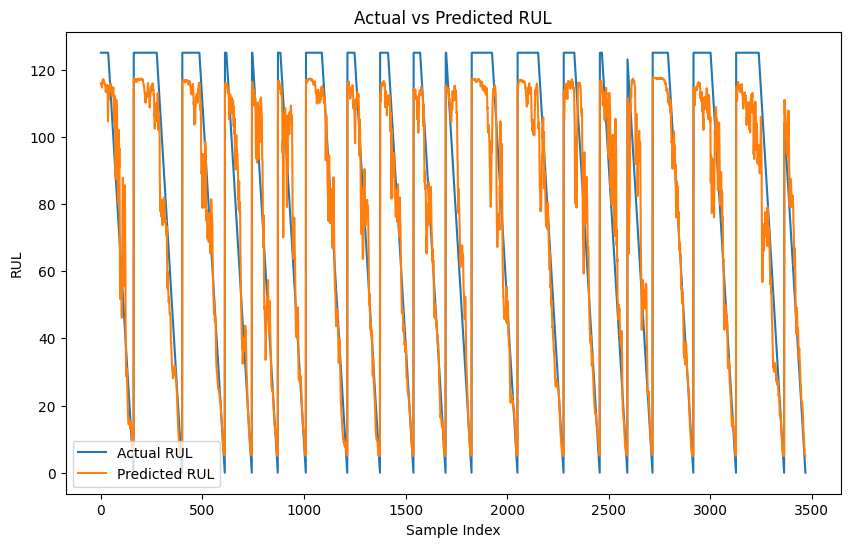

In [215]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(lstm_validation_y_test_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

### Validating Bi-LSTM

In [216]:
from sklearn.metrics import mean_squared_error
# Validation with Bi-LSTM
bi_lstm_validation_y_test_pred = bi_lstm_model.predict(X_test)
bi_lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, bi_lstm_validation_y_test_pred))
bi_lstm_validation_rmse

109/109 [==============================] - 2s 9ms/step


12.358531156582343

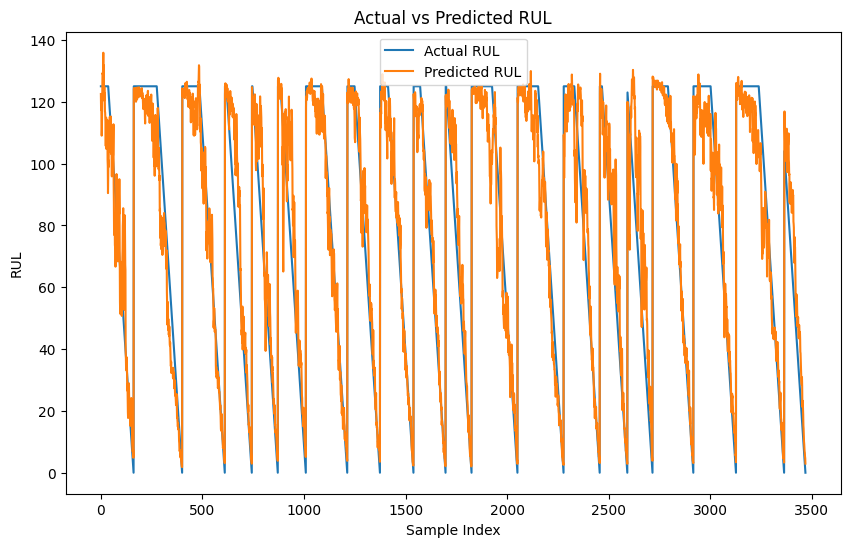

In [217]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(bi_lstm_validation_y_test_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

### Validating CNN-LSTM

In [218]:
from sklearn.metrics import mean_squared_error
# Validation with CNN-LSTM
cnn_lstm_validation_y_test_pred = cnn_lstm_model.predict(X_test)
cnn_lstm_validation_rmse = np.sqrt(mean_squared_error(y_test, cnn_lstm_validation_y_test_pred))
cnn_lstm_validation_rmse

109/109 [==============================] - 0s 2ms/step


14.238495564291668

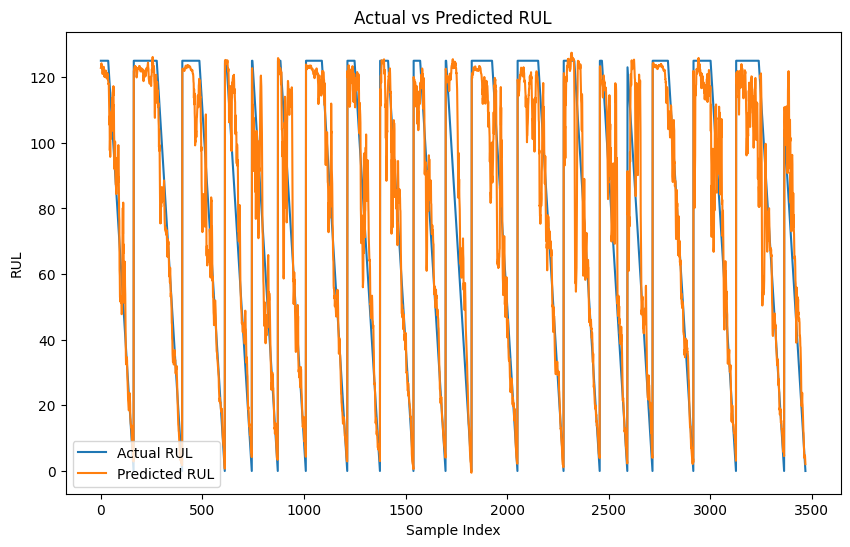

In [219]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual RUL')
plt.plot(cnn_lstm_validation_y_test_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# Prediction of Models

In [220]:
# Prepping test data
X_test = []
y_test = []
sequence_length = 30
feature_columns = [col for col in train_data.columns if col not in ['engine_id', 'cycle', 'RUL', 'PWRUL']]

for engine_id in test_df_normalized['engine_id'].unique():
    engine_data = test_df_normalized[test_df_normalized['engine_id'] == engine_id].reset_index(drop=True)
    if len(engine_data) >= sequence_length:
        # Use only the last sequence
        seq_x = engine_data[feature_columns].iloc[-sequence_length:].values
        X_test.append(seq_x)
        # Get the true RUL for this engine
        seq_y = true_rul.loc[engine_id - 1].values[0]
        y_test.append(seq_y)
    else:
        print(f"Engine {engine_id} has insufficient data for the defined sequence length.")

X_test = np.array(X_test)
y_test = np.array(y_test)

In [221]:
from sklearn.metrics import mean_squared_error

## Predict with LSTM

In [222]:
y_test_pred = lstm_model.predict(X_test)
lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
lstm_testing_rmse

4/4 [==============================] - 0s 6ms/step


14.040002271927287

4/4 [==============================] - 0s 6ms/step


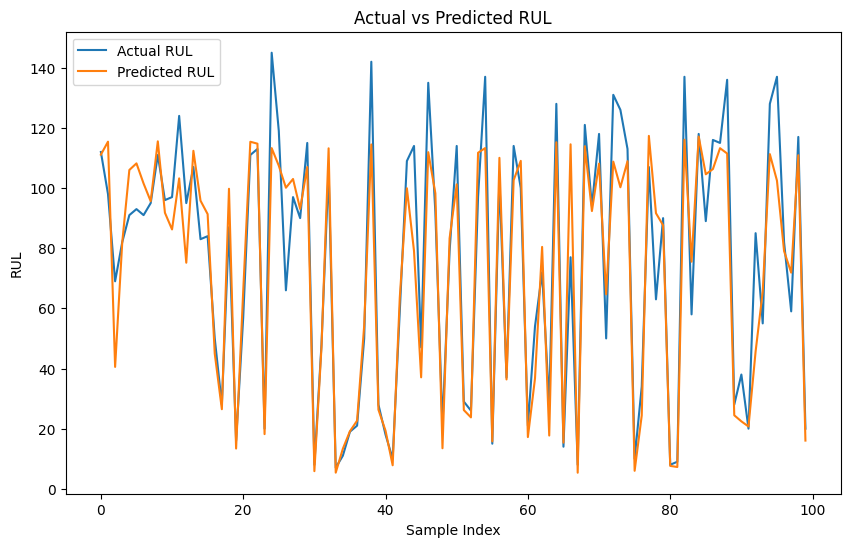

In [223]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

## Predict with Bi-LSTM

In [224]:
y_test_pred = bi_lstm_model.predict(X_test)
bi_lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
bi_lstm_testing_rmse

4/4 [==============================] - 0s 8ms/step


14.65051994745449

4/4 [==============================] - 0s 7ms/step


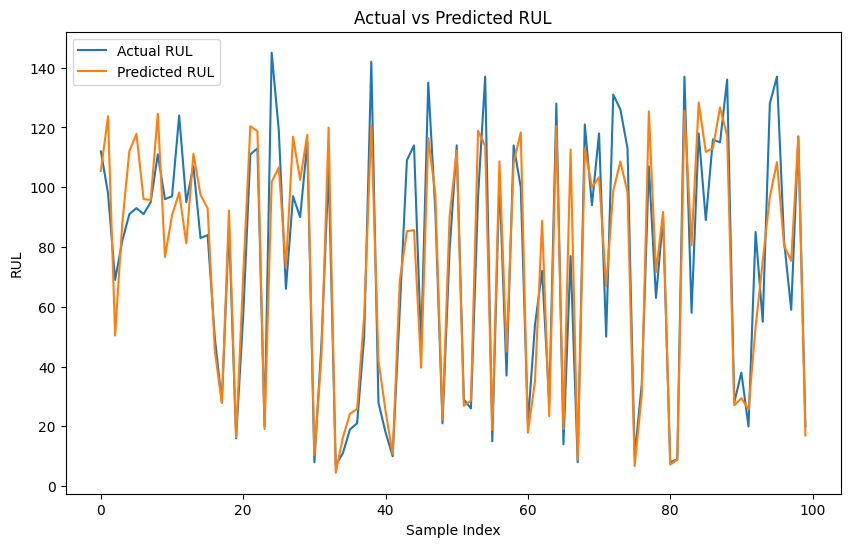

In [225]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(bi_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

## Predict with CNN-LSTM

In [226]:
y_test_pred = cnn_lstm_model.predict(X_test)
cnn_lstm_testing_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
cnn_lstm_testing_rmse

4/4 [==============================] - 0s 2ms/step


13.602634146691203

4/4 [==============================] - 0s 2ms/step


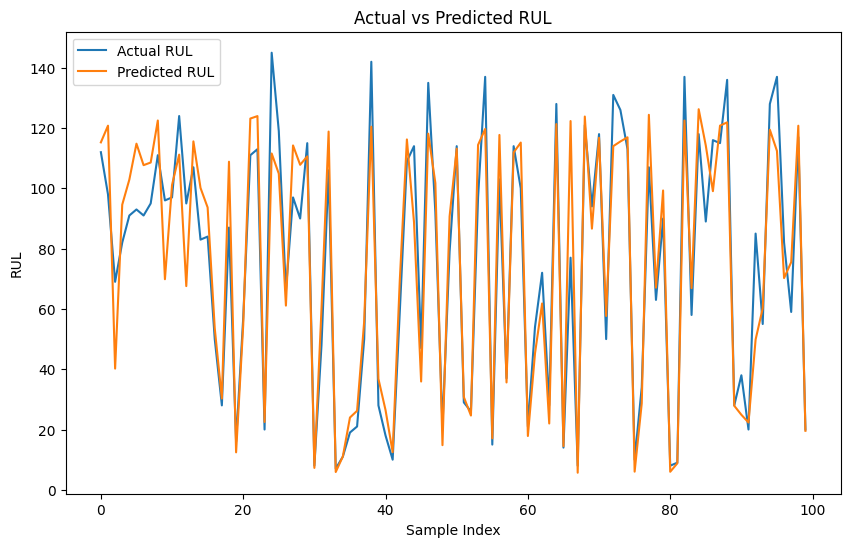

In [227]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(cnn_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# Extra Apprach (Two-Steam)
- Describe
- Link to the [codebase](./Bi-LSTM-Two-Stream-PCA-AE-Network.ipynb)

# Comparison Between Validation and Testing

In [228]:
import pandas as pd

# Create a dictionary with the results
results = {
    'Model': ['LSTM', 'CNN-LSTM', 'Bi-LSTM'],
    'Validation RMSE': [lstm_validation_rmse, cnn_lstm_validation_rmse, bi_lstm_validation_rmse],
    'Testing RMSE': [lstm_testing_rmse, cnn_lstm_testing_rmse, bi_lstm_testing_rmse]
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Set 'Model' as the index for better presentation
results_df.set_index('Model', inplace=True)

# Display the table
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
          Validation RMSE  Testing RMSE
Model                                  
LSTM            12.746839     14.040002
CNN-LSTM        14.238496     13.602634
Bi-LSTM         12.358531     14.650520


# Saving of Scale & Models

In [239]:
# MinMaxScaler
import pickle
with open('./scale/minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [240]:
# Saving LSTM Model
lstm_model.save('./models/lstm_model.h5')

In [241]:
# Saving Bi-LSTM Model
bi_lstm_model.save('./models/bi_lstm_model.h5')

In [242]:
# Saving CNN-lstm Model
cnn_lstm_model.save('./models/cnn_lstm_model.h5')

# Loading Model Instead of Retraining

In [233]:
import pickle

# with open('./scale/minmax_scaler.pkl', 'rb') as file:
#     scaler = pickle.load(file)

In [234]:
from tensorflow.keras.models import load_model

# lstm_model = load_model('./models/lstm_model.h5')
# bi_lstm_model = load_model('./models/bi_lstm_model.h5')
# cnn_lstm_model = load_model('./models/cnn_lstm_model.h5')

In [235]:
# Run Prepping of Testing Data Block on Top

# Ensemble
- Simple Average
- Weighted (?) -> giving weights to each of the model
- Stacking Ensemble

## Simple Average Ensemble

In [236]:
# Make predictions on the test set with each model
y_pred_lstm = lstm_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)
y_pred_bi_lstm = bi_lstm_model.predict(X_test)

# Reshape predictions if necessary
y_pred_lstm = y_pred_lstm.flatten()
y_pred_cnn_lstm = y_pred_cnn_lstm.flatten()
y_pred_bi_lstm = y_pred_bi_lstm.flatten()

# Simple average of predictions
y_pred_ensemble = (y_pred_lstm + y_pred_cnn_lstm + y_pred_bi_lstm) / 3

# Evaluate ensemble performance
from sklearn.metrics import mean_squared_error

rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
print(f'Ensemble RMSE (Simple Average): {rmse_ensemble:.2f}')

4/4 [==============================] - 0s 8ms/step
Ensemble RMSE (Simple Average): 13.25


## Stacking Ensemble
- Must split the training data to get teh validation set
- Validation set is used to train the meta model

In [237]:
meta_features_val = np.column_stack((y_pred_lstm, y_pred_cnn_lstm, y_pred_bi_lstm))
meta_target_val = y_test

In [238]:
# The following is wrong because we should have used the base lstm, cnn-lstm, bi-lstm models to predict validation set
# Used the validation set result to fit the linear regression
from sklearn.linear_model import LinearRegression

# Initialize the meta-model
meta_model = LinearRegression()

# Train the meta-model on the validation set predictions
meta_model.fit(meta_features_val, meta_target_val)

LinearRegression()